# Why Self Querying ?
    - semantic search is where we mainly use to retrieve data from text to obtain semantic meaning 
    - but if you want to retrieve data from like databases, you don't need semantic search but querying.
    - this is the main reason behind self-querying
    - it's sort of extracting the exact answer (self querying RAG) vs generating answer with semantic meaning (normal RAG)

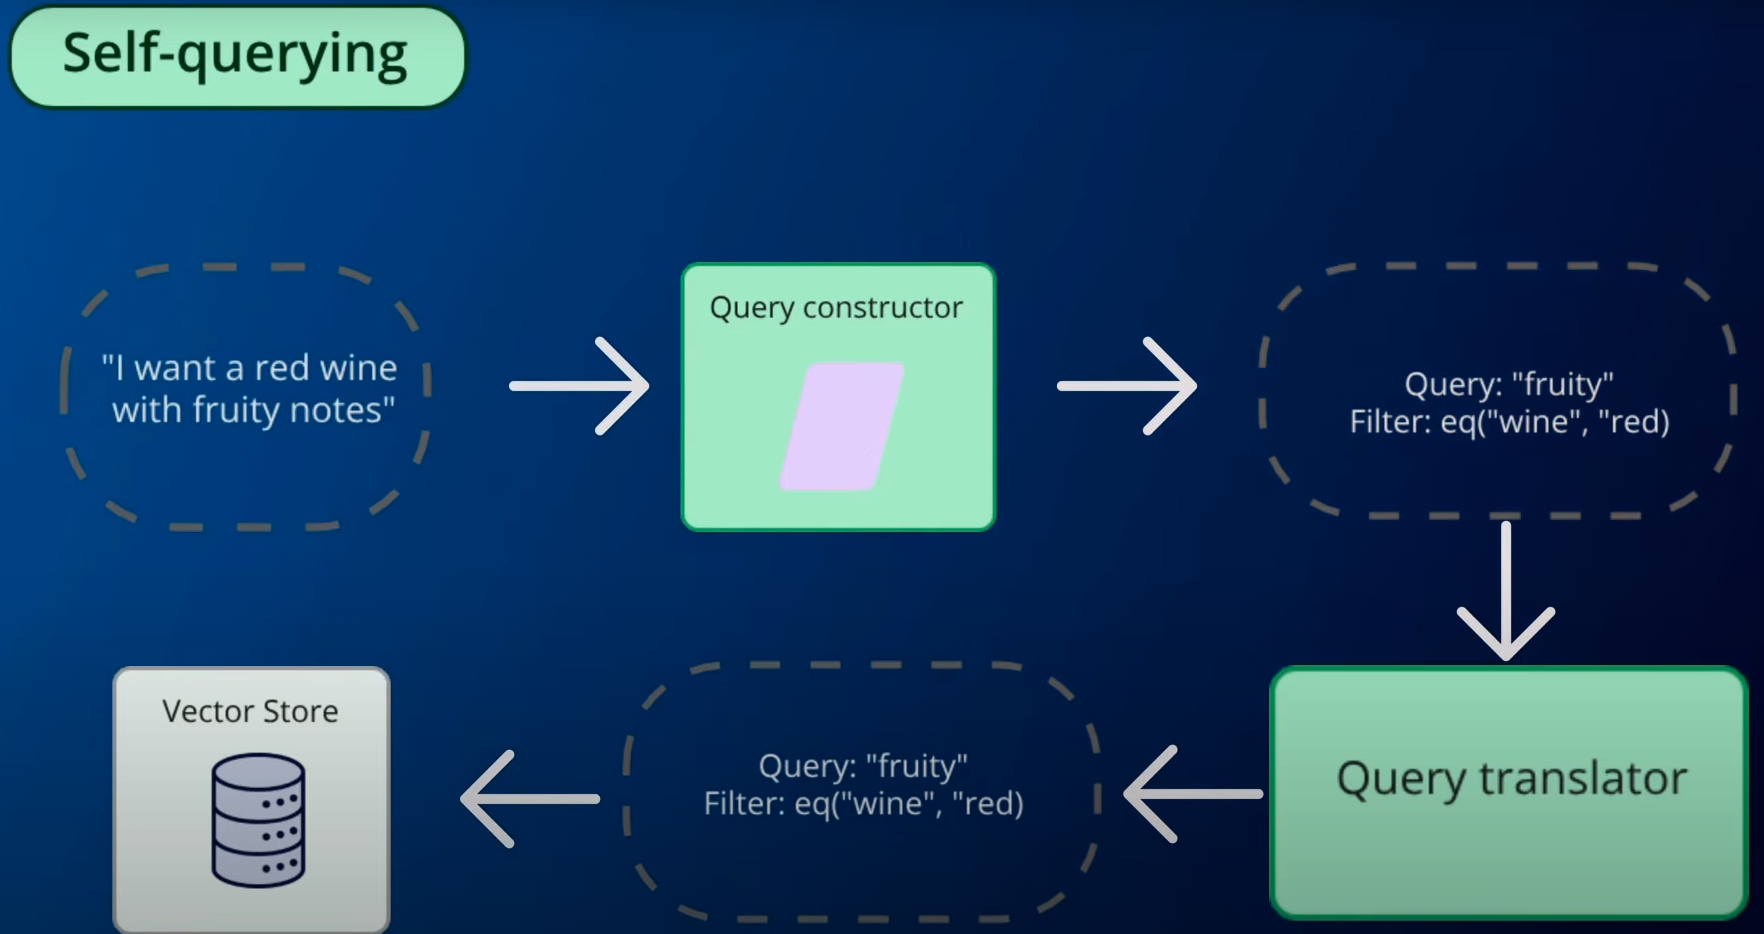

In [1]:
!pip install lark

In [2]:
import yaml, os, openai
from langchain.schema import Document
from langchain.vectorstores import Chroma
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

In [3]:
with open('cadentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.FullLoader)

os.environ['OPENAI_API_KEY'] = credentials['OPENAI_API_KEY']
os.environ['HUGGINGFACEHUB_API_TOKEN'] = credentials['HUGGINGFACEHUB_API_TOKEN']
os.environ['ENGINE'] = credentials['ENGINE']

openai.api_key = credentials['OPENAI_API_KEY']
openai.api_base = credentials['OPENAI_API_BASE']
openai.api_type = credentials['OPENAI_API_TYPE']
openai.api_version = credentials['OPENAI_API_VERSION']
openai.engine = credentials['ENGINE']

In [4]:
embeddings = HuggingFaceInstructEmbeddings(
                                        model_name="hkunlp/instructor-xl", 
                                        model_kwargs={"device": "mps"}
                                        )

/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/InstructorEmbedding/instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


load INSTRUCTOR_Transformer
'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


max_seq_length  512


# Let's create dummy docs for the usecase

In [5]:
docs = [
    Document(
        page_content="Complex, layered, rich red with dark fruit flavors",
        metadata={"name":"Opus One", "year": 2018, "rating": 96, "grape": "Cabernet Sauvignon", "color":"red", "country":"USA"},
    ),
    Document(
        page_content="Luxurious, sweet wine with flavors of honey, apricot, and peach",
        metadata={"name":"Château d'Yquem", "year": 2015, "rating": 98, "grape": "Sémillon", "color":"white", "country":"France"},
    ),
    Document(
        page_content="Full-bodied red with notes of black fruit and spice",
        metadata={"name":"Penfolds Grange", "year": 2017, "rating": 97, "grape": "Shiraz", "color":"red", "country":"Australia"},
    ),
    Document(
        page_content="Elegant, balanced red with herbal and berry nuances",
        metadata={"name":"Sassicaia", "year": 2016, "rating": 95, "grape": "Cabernet Franc", "color":"red", "country":"Italy"},
    ),
    Document(
        page_content="Highly sought-after Pinot Noir with red fruit and earthy notes",
        metadata={"name":"Domaine de la Romanée-Conti", "year": 2018, "rating": 100, "grape": "Pinot Noir", "color":"red", "country":"France"},
    ),
    Document(
        page_content="Crisp white with tropical fruit and citrus flavors",
        metadata={"name":"Cloudy Bay", "year": 2021, "rating": 92, "grape": "Sauvignon Blanc", "color":"white", "country":"New Zealand"},
    ),
    Document(
        page_content="Rich, complex Champagne with notes of brioche and citrus",
        metadata={"name":"Krug Grande Cuvée", "year": 2010, "rating": 93, "grape": "Chardonnay blend", "color":"sparkling", "country":"New Zealand"},
    ),
    Document(
        page_content="Intense, dark fruit flavors with hints of chocolate",
        metadata={"name":"Caymus Special Selection", "year": 2018, "rating": 96, "grape": "Cabernet Sauvignon", "color":"red", "country":"USA"},
    ),
    Document(
        page_content="Exotic, aromatic white with stone fruit and floral notes",
        metadata={"name":"Jermann Vintage Tunina", "year": 2020, "rating": 91, "grape": "Sauvignon Blanc blend", "color":"white", "country":"Italy"},
    ),
]
vectorstore = Chroma.from_documents(docs, embeddings)

In [6]:
metadata_field_info = [
    AttributeInfo(
        name="grape",
        description="The grape used to make the wine",
        type="string or list[string]",
    ),
    AttributeInfo(
        name="name",
        description="The name of the wine",
        type="string or list[string]",
    ),
    AttributeInfo(
        name="color",
        description="The color of the wine",
        type="string or list[string]",
    ),
    AttributeInfo(
        name="year",
        description="The year the wine was released",
        type="integer",
    ),
    AttributeInfo(
        name="country",
        description="The name of the country the wine comes from",
        type="string",
    ),
    AttributeInfo(
        name="rating", description="The Robert Parker rating for the wine 0-100", type="integer" #float
    ),
]
document_content_description = "Brief description of the wine"

In [7]:
llm = ChatOpenAI(
                openai_api_key=os.environ["OPENAI_API_KEY"],
                engine = os.environ["ENGINE"],
                model='gpt-3.5-turbo',
                temperature=0.9, 
                max_tokens = 256
                )

WARNING! engine is not default parameter.
                    engine was transferred to model_kwargs.
                    Please confirm that engine is what you intended.


In [8]:
retriever = SelfQueryRetriever.from_llm(
                                        llm,
                                        vectorstore,
                                        document_content_description,
                                        metadata_field_info,
                                        verbose=True
                                        )

In [9]:
# This example only specifies a relevant query
retriever.get_relevant_documents("What are some red wines")

/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/langchain/chains/llm.py:280: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


query='red' filter=None limit=None


[Document(page_content='Elegant, balanced red with herbal and berry nuances', metadata={'color': 'red', 'country': 'Italy', 'grape': 'Cabernet Franc', 'name': 'Sassicaia', 'rating': 95, 'year': 2016}),
 Document(page_content='Complex, layered, rich red with dark fruit flavors', metadata={'color': 'red', 'country': 'USA', 'grape': 'Cabernet Sauvignon', 'name': 'Opus One', 'rating': 96, 'year': 2018}),
 Document(page_content='Full-bodied red with notes of black fruit and spice', metadata={'color': 'red', 'country': 'Australia', 'grape': 'Shiraz', 'name': 'Penfolds Grange', 'rating': 97, 'year': 2017}),
 Document(page_content='Highly sought-after Pinot Noir with red fruit and earthy notes', metadata={'color': 'red', 'country': 'France', 'grape': 'Pinot Noir', 'name': 'Domaine de la Romanée-Conti', 'rating': 100, 'year': 2018})]

In [10]:
# This example specifies a query and a filter
retriever.get_relevant_documents("I want a wine that has fruity nodes and has a rating above 97")

query='fruity' filter=Comparison(comparator=<Comparator.GT: 'gt'>, attribute='rating', value=97) limit=None


[Document(page_content='Luxurious, sweet wine with flavors of honey, apricot, and peach', metadata={'color': 'white', 'country': 'France', 'grape': 'Sémillon', 'name': "Château d'Yquem", 'rating': 98, 'year': 2015}),
 Document(page_content='Highly sought-after Pinot Noir with red fruit and earthy notes', metadata={'color': 'red', 'country': 'France', 'grape': 'Pinot Noir', 'name': 'Domaine de la Romanée-Conti', 'rating': 100, 'year': 2018})]